In [ ]:
# Load libraries needed for the symbolics
using Symbolics
using SpecialFunctions
using Plots

In [ ]:
# Define simulation parameters
λ = 550e-9;  # wavelength in meters
a = 20e-9;  # particle radius in meters
nₘ = 1.33;    # Refractive index of the medium 
nₚ = 0.47 + 2.41im;    # Refractive index of the particle at 550 nm
x = 2π * a * n_medium / λ;  # Relative size parameter
m = n_particle / n_medium;   # Relative refractive index

For the Mie solution, we gotta compute the sperical Bessel and Hankel functions
- $j_n(x)$: Spherical Bessel function of the first kind
- $h_{n}^{(1)}$: Spherical Hankel funciton of the first kind
- $j_n(mx), h_n(mx)$ the derivatives of the funcitons

With this, we can build the Mie scattering coefficients $(a_n, b_n)$ which describe the electric and magnetic multidipole contributions
$$
\begin{equation*}
a_n = \frac{m\psi_n(mx)\psi_{n}^{'}(x) - \psi_{n}(x)\psi_{n}^{'}(mx)}{m\psi_n(mx)\xi_{n}^{'}(x) - \xi_{n}(x)\psi_{n}^{'}(mx)}
\end{equation*}
$$

$$
\begin{equation*}
b_n = \frac{\psi_n(mx)\psi_{n}^{'}(x) - m\psi_{n}(x)\psi_{n}^{'}(mx)}{\psi_n(mx)\xi_{n}^{'}(x) - m\xi_{n}(x)\psi_{n}^{'}(mx)}
\end{equation*}
$$

Where:
- $\psi_n(z) = zj_n(z)$
- $\xi_n(z) = zh_n^{(1)}(z)$

We compute this until the Mie series converges, it is known that for a parameter x that defines how large is the particle relative to the wevalength $x = \frac{2\pi a}{\lambda}$, the bigger the x the more terms for the Mie series are gonna be needed to take into account the multipoles contributions, empirically an upper bound has been found following:

$$
\begin{equation*}
N_{max} = x + 4x^{1/3} + 2
\end{equation*}
$$

This will ensure all multipoles have been taken into account.



In [ ]:
# Spherical Bessel and Hankel functions for the Mie solution
function mie_coefficients(n, x, m)
    # Bessel functions
    psi_n(z) = z * sphericalbesselj(n, z)
    xi_n(z) = z * (sphericalbesselj(n, z) + im * sphericalbessely(n, z))

    psi_x = psi_n(x)
    psi_mx = psi_n(m * x)
    psi_x_der = sphericalbesselj(n, x) + x * sphericalbesselj(n-1, x) - n * sphericalbesselj(n, x) / x
    psi_mx_der = sphericalbesselj(n, m * x) + m * x * sphericalbesselj(n-1, m * x) - n * sphericalbesselj(n, m * x) / (m * x)
    
    xi_x = xi_n(x)
    xi_x_der = sphericalbesselj(n, x) + im * sphericalbessely(n, x) + x * (sphericalbesselj(n-1, x) + im * sphericalbessely(n-1, x)) - n * xi_n(x) / x

    a_n = (m * psi_mx * psi_x_der - psi_x * psi_mx_der) / (m * psi_mx * xi_x_der - xi_x * psi_mx_der)
    b_n = (psi_mx * psi_x_der - m * psi_x * psi_mx_der) / (psi_mx * xi_x_der - m * xi_x * psi_mx_der)

    return a_n, b_n
end

function scattering_efficiency(x, m; Nmax=20)
    Q_sca = 0.0
    for n in 1:Nmax
        a_n, b_n = mie_coefficients(n, x, m)
        Q_sca += (2n + 1) * (abs2(a_n) + abs2(b_n))
    end
    return (2 / x^2) * Q_sca
end

In [1]:
# Load data for gold
module AuOpticalData

using DelimitedFiles
using Interpolations

export load_Au_data, Au_nk, Au_ϵ

function load_Au_data(filepath)
    raw = readdlm(filepath, ',', skipstart=1)
    λ_um = raw[:, 1]
    n_vals = raw[:, 2]
    k_vals = raw[:, 3]

    λ_m = λ_um .* 1e-6  # microns → meters

    n_interp = LinearInterpolation(λ_m, n_vals)
    k_interp = LinearInterpolation(λ_m, k_vals)

    Au_nk(λ::Float64) = complex(n_interp(λ), k_interp(λ))
    Au_ϵ(λ::Float64) = Au_nk(λ)^2

    return Au_nk, Au_ϵ
end

end

# Import and Load the data
using .AuOpticalData

# Au data
Au_nk, Au_ϵ = load_Au_data("Johnson.csv");

In [2]:
# Calculate Polarizability
function polarizability_qs(λ_m, R, ε_m)
    ε = Au_ϵ(λ_m)                              # dielectric function in m
    α_vol = 4π * R^3 * (ε - ε_m) / (ε + 2ε_m)
    α_SI = ϵ0 * α_vol   # Multiply by ϵ0 to get SI 
    return α_SI
end

polarizability_qs (generic function with 1 method)

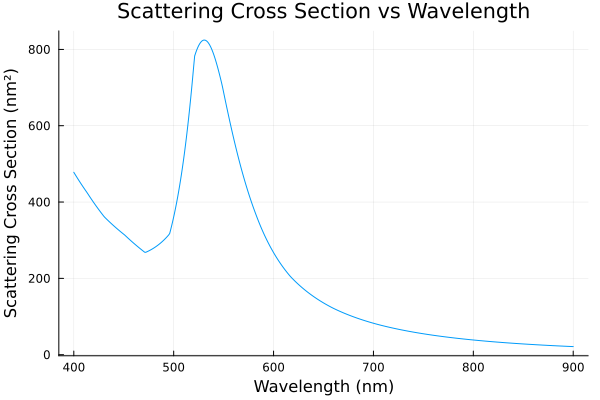

In [3]:
using Plots

# Constants
const ϵ0 = 8.854187817e-12      # Vacuum permittivity (F/m)
const nm_to_m = 1e-9            # Nanometers to meters

# Medium parameters
ε_m = 1.77                     # Dielectric constant of medium (water)
n_m = sqrt(ε_m)                # Refractive index of medium

# Particle parameters
R_nm = 25.0                   # Radius in nm
R = R_nm * nm_to_m            # Convert radius to m

# Wavelength range in nanometers
λs_nm = 400.0:1.0:900.0
λs_m = λs_nm .* nm_to_m       # Convert wavelength range to m

# Calculate scattering cross section (in m²)
σ_scat = Float64[]

for (λ_nm, λ_m) in zip(λs_nm, λs_m)
    α = polarizability_qs(λ_m, R, ε_m)  # use SI units
    k = 2π * n_m / λ_m
    σ = (k^4) / (6π * ϵ0^2) * abs(α)^2
    push!(σ_scat, σ)
end

# Plot & convert from m² to nm²
plot(λs_nm, σ_scat .* 1e18, xlabel = "Wavelength (nm)", ylabel = "Scattering Cross Section (nm²)", title = "Scattering Cross Section vs Wavelength", legend = false)


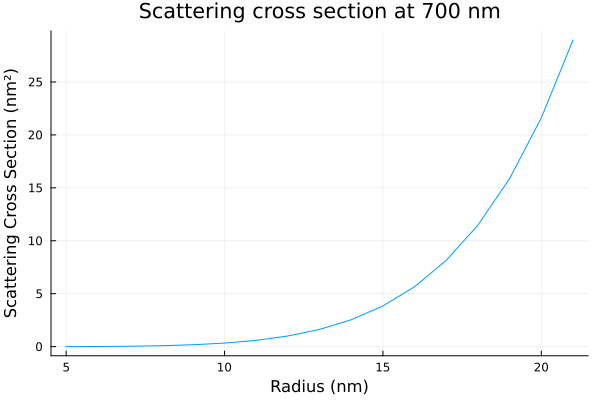

In [3]:
using Plots

# Constants
const ϵ0 = 8.854187817e-12      # Vacuum permittivity (F/m)
const nm_to_m = 1e-9            # Nanometers to m

# Medium parameters
ε_m = 1.77                     # Dielectric constant of medium (water)
n_m = sqrt(ε_m)                # Refractive index of medium

# Fixed wavelength for resonance in m
λ_nm = 700.0
λ_m = λ_nm * nm_to_m

# Radii range in nm
radii_nm = 5:1.0:21.0
radii_m = radii_nm .* nm_to_m

# Polarizability function
function polarizability_qs(λ_m, R_m, ε_m)
    ε = Au_ϵ(λ_m)                              # Dielectric function at a given λ
    α_vol = 4π * R_m^3 * (ε - ε_m) / (ε + 2ε_m)
    α_SI = ϵ0 * α_vol   # Convert to SI units
    return α_SI
end

# Calculate scattering cross sections
σ_scat = Float64[]

for R in radii_m
    α = polarizability_qs(λ_m, R, ε_m)
    k = 2π * n_m / λ_m
    σ = (k^4) / (6π * ϵ0^2) * abs(α)^2
    push!(σ_scat, σ)
end

# Plot scattering cross section vs radius
titleplot = "Scattering Cross Section vs Radius at ", λ_nm, " nm²"
plot(radii_nm, σ_scat .* 1e18, xlabel = "Radius (nm)", ylabel = "Scattering Cross Section (nm²)", title = "Scattering cross section at 700 nm", legend = false)
